In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
# 데이터셋 다운로드
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

# 압축 풀기
!unzip -q cats_and_dogs_filtered.zip


--2025-06-07 06:38:42--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.207, 74.125.20.207, 108.177.98.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   223MB/s    in 0.3s    

2025-06-07 06:38:42 (223 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
# 데이터 폴더
base_dir = 'cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# 데이터 폴더/train data/cats
# 데이터 폴더/train data/dogs
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
print(f"train_cats_dir:{train_cats_dir}")
print(f"train_dogs_dir:{train_dogs_dir}")

# 데이터 폴더/test data/cats
# 데이터 폴더/test data/dogs
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# 데이터 폴더/train data/cats에 있는 파일
# 데이터 폴더/train data/dogs에 있는 파일
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

print(f"train_cat_fnames[:10]:{train_cat_fnames[:10]}")
print(f"train_dog_fnames[:10]:{train_dog_fnames[:10]}")

# training total number cats and dogs images in train and validation set
num_cats_train = len(os.listdir(train_cats_dir))
num_dogs_train = len(os.listdir(train_dogs_dir))

print("number of cats in train dir     : ", num_cats_train)
print("number of dogs in train dir     : ", num_dogs_train)

num_cats_validation = len(os.listdir(validation_cats_dir))
num_dogs_validation = len(os.listdir(validation_dogs_dir))

print('total validation cat images :', num_cats_validation)
print('total validation dog images :', num_dogs_validation)

total_train = num_cats_train + num_dogs_train
total_validation = num_cats_validation + num_dogs_validation

print("Total training images:", total_train)
print("Total validation images:", total_validation)


train_cats_dir:cats_and_dogs_filtered/train/cats
train_dogs_dir:cats_and_dogs_filtered/train/dogs
train_cat_fnames[:10]:['cat.456.jpg', 'cat.390.jpg', 'cat.267.jpg', 'cat.69.jpg', 'cat.143.jpg', 'cat.731.jpg', 'cat.392.jpg', 'cat.888.jpg', 'cat.598.jpg', 'cat.766.jpg']
train_dog_fnames[:10]:['dog.428.jpg', 'dog.652.jpg', 'dog.567.jpg', 'dog.833.jpg', 'dog.890.jpg', 'dog.970.jpg', 'dog.273.jpg', 'dog.290.jpg', 'dog.194.jpg', 'dog.919.jpg']
number of cats in train dir     :  1000
number of dogs in train dir     :  1000
total validation cat images : 500
total validation dog images : 500
Total training images: 2000
Total validation images: 1000


In [ ]:
BATCH_SIZE = 100 # 한 번에 100장의 사진(데이터)을 가져와서 학습시킨다는 뜻이야.
EPOCHS = 100 # 전체 데이터를 몇 번 반복 학습할 건지 정하는 값이야.
IMG_HEIGHT = 150 #  사진 크기를 150x150 픽셀로 고정
IMG_WIDTH = 150

# seed 값 설정
seed = 15 # 랜덤 결과 고정 (언제 돌려도 동일하게)
np.random.seed(seed)
tf.random.set_seed(seed)

1️⃣ rescale=1./255
👉 원래 이미지 픽셀 값은 0~255 사이야 (흑백이면 0255, 컬러면 각 색마다 0255)

→ 신경망은 0~1 사이 값에서 더 잘 학습함.

In [ ]:
#train_generator → "학습용 데이터" 준비. 그냥 **"어떻게 변형할지 레시피(설정)만 저장"**한 상태. 이미지는 아직 손도 안 댐!
train_datagen = ImageDataGenerator(
    rescale=1./255, # 정규화(normalization)
    rotation_range=40, # 최대 40도까지 랜덤으로 회전
    width_shift_range=0.2, # 가로 방향으로 최대 20% 랜덤 이동
    height_shift_range=0.2, # 세로 방향으로 최대 20% 랜덤 이동
    shear_range=0.2, # 비스듬하게 찌그러뜨리기
    zoom_range=0.2, # 최대 20%까지 랜덤하게 확대/축소
    horizontal_flip=True, # 좌우반전
    fill_mode='nearest' # 회전하거나 이동해서 빈 공간이 생기면 → 그 공간을 "가장 가까운 색으로 채우기".
)

In [ ]:
"""
폴더에 있는 사진들을 자동으로 읽어서 → 변형(augmentation) 적용 → 학습할 준비가 된 "데이터 묶음"을 만들어주는 코드야.
(generator: 데이터를 한 덩어리씩 "흘려주는" 애)

📌 "그럼 3가지 이상 (고양이, 강아지, 말, 호랑이)" → 어떻게?
👉 그때는 class_mode='categorical' 로 바꿔주면 돼!

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    classes=['cats', 'dogs', 'horses', 'tigers'],  # 폴더 이름에 맞춰!
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='categorical'   # <--- 이거 변경!

| class\_mode     | 결과 라벨 형식             | 예시 (클래스 4개: 고양이, 개, 말, 호랑이)                        |
| --------------- | -------------------- | -------------------------------------------------- |
| `'binary'`      | 0 or 1 (정수값)         | 못 사용함 (오류 발생)                                      |
| `'categorical'` | **원-핫 벡터 (one-hot)** | `[1,0,0,0]`, `[0,1,0,0]`, `[0,0,1,0]`, `[0,0,0,1]` |


| 2개 클래스 (binary)                  | 3개 이상 클래스 (categorical)                    |
| -------------------------------- | ------------------------------------------ |
| `class_mode='binary'`            | `class_mode='categorical'`                 |
| `Dense(1, activation='sigmoid')` | `Dense(N, activation='softmax')` (N=클래스 수) |
"""
train_generator = train_datagen.flow_from_directory( # 그냥 "데이터 흐름 준비(generator 세팅)"만 한 상태.  "필요할 때 그때그때 이미지를 읽어서 numpy로 변환해주는 기계"를 만든 것
    directory=train_dir, # cats_and_dogs_filtered/train
    classes=['cats', 'dogs'], # 'cats' → 고양이 → label 0, 'dogs' → 강아지 → label 1   이렇게 라벨을 자동으로 붙여줌
    batch_size=BATCH_SIZE, # 한 번에 몇 장씩 읽어올지 정함
    shuffle=True, # 랜덤으로 섞어서
    target_size=(IMG_HEIGHT, IMG_WIDTH), # 이미지를 150x150으로 resize 해서 가져옴
    class_mode='binary' # 라벨이 0 또는 1로
)

# validation (검증) 용 데이터를 준비
validation_datagen = ImageDataGenerator(rescale=1./255) # 픽셀 값만 0~1로 정규화.   검증 데이터는 "진짜 평가"니까 → 원본 그대로 평가하는 게 좋음

validation_generator = validation_datagen.flow_from_directory(
    directory=validation_dir,
    classes=['cats', 'dogs'],
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


"""
📌 왜 학습 + 검증 둘 다 필요할까?
만약:
학습만 시키면 → "기억"만 해서 잘 외우는 경우가 있어.
→ 새 사진 나오면 못 맞춤 → 과적합(overfitting)!

그래서:
학습할 때 중간중간 → 검증용 데이터로 "시험" 을 봄
→ 진짜 잘 배우고 있는지 확인!


| `train_datagen = ImageDataGenerator(...)` | `train_generator = train_datagen.flow_from_directory(...)` |
| ----------------------------------------- | ---------------------------------------------------------- |
| "사진 가공기계" (세팅만 한 것)                       | "가공된 사진을 쟁반에 담아서 흘려주는 기계" (실제 데이터 만드는 단계)                  |
| 가공 규칙(설정)만 담고 있음                          | 실제로 사진 폴더에서 읽어서, 가공해서, "학습용 데이터 흐름"을 만들어냄                  |
| 아직 데이터를 만들진 않음                            | 데이터를 만들어서 model.fit() 에 넘길 준비가 됨                           |

"""

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


'\n📌 왜 학습 + 검증 둘 다 필요할까?\n만약:\n학습만 시키면 → "기억"만 해서 잘 외우는 경우가 있어.\n→ 새 사진 나오면 못 맞춤 → 과적합(overfitting)!\n\n그래서:\n학습할 때 중간중간 → 검증용 데이터로 "시험" 을 봄\n→ 진짜 잘 배우고 있는지 확인!\n\n\n| `train_datagen = ImageDataGenerator(...)` | `train_generator = train_datagen.flow_from_directory(...)` |\n| ----------------------------------------- | ---------------------------------------------------------- |\n| "사진 가공기계" (세팅만 한 것)                       | "가공된 사진을 쟁반에 담아서 흘려주는 기계" (실제 데이터 만드는 단계)                  |\n| 가공 규칙(설정)만 담고 있음                          | 실제로 사진 폴더에서 읽어서, 가공해서, "학습용 데이터 흐름"을 만들어냄                  |\n| 아직 데이터를 만들진 않음                            | 데이터를 만들어서 model.fit() 에 넘길 준비가 됨                           |\n\n'

In [ ]:
print(type(train_generator))

<class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>


In [ ]:
# Model Creation.   [ Conv2D → MaxPooling → Conv2D → MaxPooling → Conv2D → MaxPooling → Flatten → Dense → Dense → Dense(출력) ]
model = tf.keras.models.Sequential([ # 층(layer)를 "위에서 아래로 순서대로" 쌓는 구조.   신경망(Neural Network) 모델을 만드는 부분
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)), # 이미지 특징(feature)를 뽑아냄. 필터 16개, 필터 크기 (3x3짜리 창으로 이미지 훑기), ReLU → 비선형성 추가, 입력 크기 (150x150, 컬러 → R/G/B → 3채널)
    tf.keras.layers.MaxPooling2D(2, 2), # 2x2 영역에서 가장 큰 값(max) 만 남김. 이미지 크기 절반으로 줄어듦 → 계산량 ↓ → 중요 특징만 남김.   보통 3~4번 정도까지만 하는 게 일반적

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'), # 더 복잡한 특징 학습 (예: 고양이 눈, 개 귀 같은 패턴들!)
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'), # 더 고차원적인 특징 학습 (예: 고양이 전체 얼굴, 개 전체 몸통 패턴 등)
    tf.keras.layers.MaxPooling2D(2, 2), # 18 * 18 크기가 됨

    tf.keras.layers.Flatten(), # 지금까지 나온 2D 이미지 특징맵을 1D 벡터로 펴기
    tf.keras.layers.Dense(512, activation='relu'), # 완전 연결 층(Dense layer).    뉴런 512개 → 복잡한 조합 학습
    tf.keras.layers.Dense(64, activation='relu'), # 또 한 번 Dense layer.   더 깊은 패턴 학습
    tf.keras.layers.Dense(1, activation='sigmoid') # 출력층.   sigmoid → 출력값이 0~1 사이로 나옴
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# compiling the model
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    metrics=['accuracy']
)

In [ ]:
"""
첫 번째 batch 요청 → generator가 그때 폴더에서 이미지 읽음 → numpy로 변환 → 모델에 넘김
다음 batch 요청 → 또 그때 읽음 → 변환 → 넘김
"""
"""
모델이 학습을 시작함!

train_generator에서 데이터를 "조금씩 가져와서"

모델이 "학습"을 하고

매 epoch마다 "시험(validation)" 도 보면서 학습 성능을 기록함

그 결과가 history에 저장됨 → 나중에 그래프도 그릴 수 있어

"""
# 모델 학습
history = model.fit( # numpy로 바뀌는 순간
    train_generator, # 학습용 데이터 (generator 형태)
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))), # epoch 당 몇 번 batch를 학습할지 정하는 값. 2000 / 100 = 20 steps.   → 한 epoch(1번 전체 학습)에서 → 20번 batch 학습함
    epochs=EPOCHS, # 총 몇 epoch 동안 학습할지 → 앞에서 EPOCHS = 100이면 100번 반복 학습
    validation_data=validation_generator, # 검증용 데이터 generator. 학습 중간중간 시험(validation)을 봄 → 성능 확인용
    validation_steps=int(np.ceil(total_validation / float(BATCH_SIZE))) # 검증할 때 몇 step(batch)를 돌릴지 정함. 1000 / 100 = 10 steps.   검증할 때 10번 batch를 평가함
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 711ms/step - accuracy: 0.5111 - loss: 0.7784 - val_accuracy: 0.5880 - val_loss: 0.6914
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 681ms/step - accuracy: 0.5345 - loss: 0.6907 - val_accuracy: 0.5000 - val_loss: 0.6877
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 679ms/step - accuracy: 0.5373 - loss: 0.6871 - val_accuracy: 0.5200 - val_loss: 0.6709
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 680ms/step - accuracy: 0.5353 - loss: 0.6830 - val_accuracy: 0.5270 - val_loss: 0.6900
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 683ms/step - accuracy: 0.5515 - loss: 0.6862 - val_accuracy: 0.6290 - val_loss: 0.6563
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 742ms/step - accuracy: 0.5824 - loss: 0.6720 - val_accuracy: 0.5260 - val_loss: 0.6687
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 692ms/step - accuracy: 0.5892 - loss: 0.6706 - val_accuracy: 0.5840 - val_loss: 0.6652
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 680ms/step - accuracy: 0.5976 - loss: 0.6667 - 

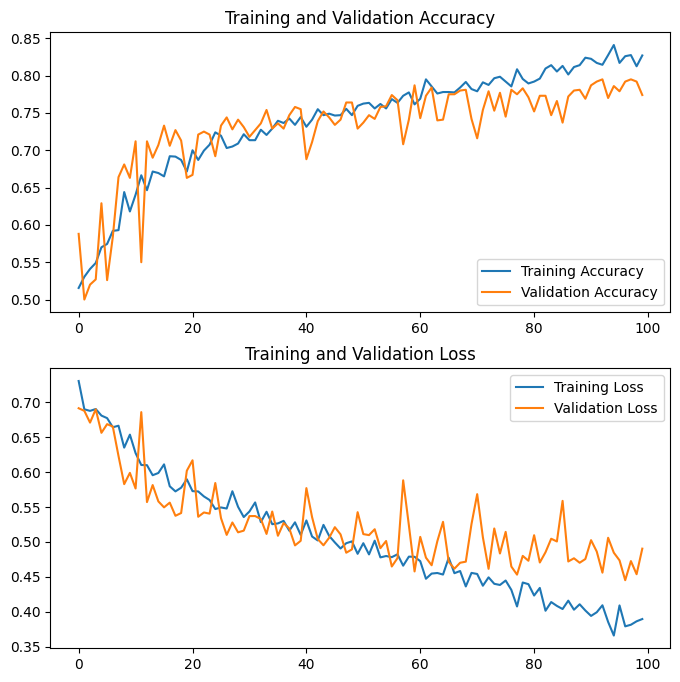

In [ ]:
# 정확도와 손실함수 시각화
acc =history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range=range(EPOCHS)
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2,1,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
"""
폴더에 2000장 있음 (jpg, png)

1️⃣ train_datagen = ImageDataGenerator(...)
    → 그냥 레시피 설정만 함 → 이미지 그대로 있음

2️⃣ train_generator = train_datagen.flow_from_directory(...)
    → generator 기계 만듦 → 아직 numpy 변환 안됨 → 폴더 그대로 존재

3️⃣ model.fit(train_generator) 시작
    → 첫 batch 요청 시:
        - 폴더에서 100장 읽음
        - numpy로 변환
        - 모델 학습
    → 두 번째 batch 요청 시:
        - 또 100장 읽음
        - numpy로 변환
        - 모델 학습
    → 반복

"""
"""
| 상황                    | 추천 구조                                                         |
| --------------------- | ------------------------------------------------------------- |
| 처음 배우는 CNN → 고양이/개 구분 | Conv2D → MaxPool → Conv2D → MaxPool → Conv2D → MaxPool (총 3번) |
| 복잡한 이미지 분류            | Conv2D → Conv2D → MaxPool → Conv2D → Conv2D → MaxPool → (반복)  |
| 고성능 (VGG16 예시)        | Conv2D x 13 + FC                                              |

"""

VGG16 모델로 변경

모델 빌드

빌드모델로 실제 판별 하기